<a href="https://colab.research.google.com/github/gunikapahwa27/RAVDESS_AI/blob/main/main/ravdessAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kagglehub

In [2]:
import kagglehub

# Download latest version of the RAVDESS dataset
path = kagglehub.dataset_download("orvile/ravdess-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'ravdess-dataset' dataset.
Path to dataset files: /kaggle/input/ravdess-dataset


In [3]:
import librosa
import librosa.display
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score

SAMPLE_RATE = 22050 # Sampling rate for audio loading
DURATION = 3 # Duration of each audio clip
N_MELS = 128 # Number of Mel bands
MAX_FRAMES = 130 # Fixed time dimension for padding
# Emotion label mapping according to RAVDESS documentation
EMOTION_MAP = {
    "01": "Neutral",
    "02": "Calm",
    "03": "Happy",
    "04": "Sad",
    "05": "Angry",
    "06": "Fearful",
    "07": "Disgust",
    "08": "Surprised"
}
# AUDIO PREPROCESSING FUNCTIONS

def trim_silence(audio):
    # Removes silent portions from the beginning and end of the audio signal
    trimmed_audio, _ = librosa.effects.trim(audio, top_db=20)
    return trimmed_audio

def add_noise(audio):
    # Adds low-amplitude Gaussian noise for data augmentation
    noise = np.random.randn(len(audio))
    return audio + 0.005 * noise

def pitch_shift(audio, sr):
    # Randomly shifts pitch up or down
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=np.random.uniform(-2, 2))

def time_stretch(audio):
    # Randomly stretches or compresses audio in time
    return librosa.effects.time_stretch(audio, rate=np.random.uniform(0.8, 1.2))

def extract_log_mel(audio, sr):
    # Converts audio waveform into Log-Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=N_MELS)
    log_mel = librosa.power_to_db(mel_spec, ref=np.max)
    # Pads or truncates spectrogram to ensure uniform shape
    if log_mel.shape[1] < MAX_FRAMES:
        pad_width = MAX_FRAMES - log_mel.shape[1]
        log_mel = np.pad(log_mel, pad_width=((0,0),(0,pad_width)))
    else:
        log_mel = log_mel[:, :MAX_FRAMES]
    return log_mel

X = []
y = []
gender_labels = []

dataset_path = "/kaggle/input/ravdess-dataset"

for file in glob.glob(os.path.join(dataset_path, "**/*.wav"), recursive=True):
    filename = os.path.basename(file)
    # Load audio file
    audio, sr = librosa.load(file, sr=SAMPLE_RATE, duration=DURATION)
    # Trim silence
    audio = trim_silence(audio)
    # Extract base features
    mel = extract_log_mel(audio, sr)
    X.append(mel)
    # Extract emotion label from filename
    emotion_code = filename.split("-")[2]
    y.append(int(emotion_code) -1)
    # Extract gender (odd actor ID = male, even = female)
    actor_id = int(filename.split("-")[-1].split(".")[0])
    gender_labels.append("Male" if actor_id % 2 else "Female")
    # Data augmentation applied only once per sample
    augmented_audio = add_noise(audio)
    mel_aug = extract_log_mel(augmented_audio, sr)
    X.append(mel_aug)
    y.append(int(emotion_code) - 1)
    gender_labels.append("Male" if actor_id % 2 else "Female")

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Add channel dimension for CNN
X = X[..., np.newaxis]

# One-hot encode labels
y_cat = to_categorical(y, num_classes=8)

In [4]:
#TRAIN VALIDATION TEST SPLIT


X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_cat, test_size=0.2, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=np.argmax(y_temp, axis=1), random_state=42
)

In [5]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))

model.add(Dense(8, activation='softmax'))

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1000,
    batch_size=32
)
est_loss, test_acc = model.evaluate(X_test, y_test)

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

macro_f1 = f1_score(y_true, y_pred, average='macro')

print("Test Accuracy:", test_acc)
print("Macro F1 Score:", macro_f1)

Epoch 1/1000
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.4801 - loss: 1.4203 - val_accuracy: 0.2997 - val_loss: 2.0593
Epoch 2/1000
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4673 - loss: 1.4115 - val_accuracy: 0.3061 - val_loss: 2.0116
Epoch 3/1000
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4942 - loss: 1.3844 - val_accuracy: 0.3061 - val_loss: 1.9711
Epoch 4/1000
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4985 - loss: 1.3952 - val_accuracy: 0.3214 - val_loss: 1.9268
Epoch 5/1000
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4916 - loss: 1.3904 - val_accuracy: 0.3099 - val_loss: 2.0209
Epoch 6/1000
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.4937 - loss: 1.3484 - val_accuracy: 0.2742 - val_loss: 2.2361
Epoch 7/1000
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4868 - loss: 1.3420 - val_accuracy: 0.2946 - val_loss: 2.0142
Epoch 8/1000
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5010 - loss: 1

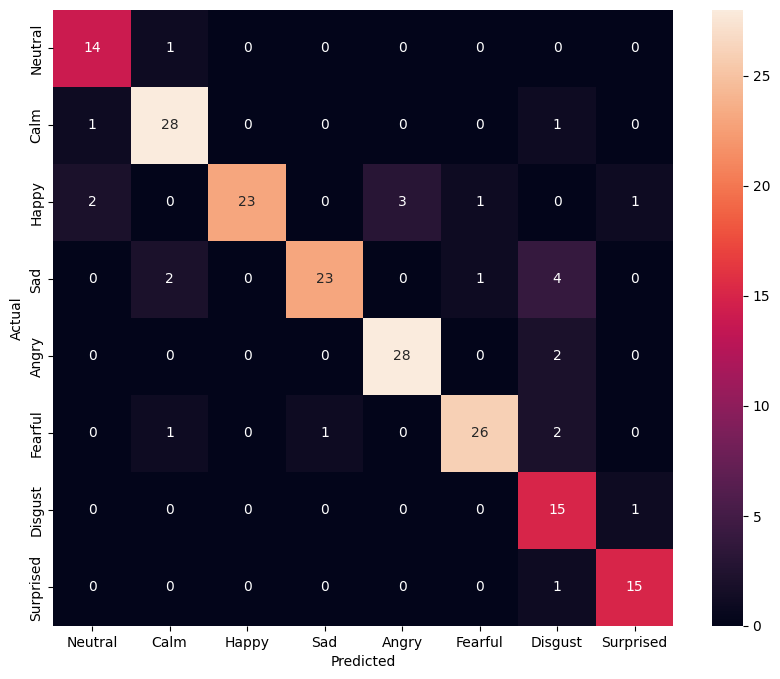

In [10]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=EMOTION_MAP.values(), yticklabels=EMOTION_MAP.values())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [11]:
#GENDER BIAS ANALYSIS
male_idx = [i for i, g in enumerate(gender_labels[:len(y_true)]) if g == "Male"]
female_idx = [i for i, g in enumerate(gender_labels[:len(y_true)]) if g == "Female"]

male_f1 = f1_score(y_true[male_idx], y_pred[male_idx], average='macro')
female_f1 = f1_score(y_true[female_idx], y_pred[female_idx], average='macro')

print("Male Speaker Macro F1:", male_f1)
print("Female Speaker Macro F1:", female_f1)

Male Speaker Macro F1: 0.8880712237079671
Female Speaker Macro F1: 0.8372909634172505


In [12]:

model.save("ser_cnn_model.h5")

In [13]:

def predict_emotion(file_path):
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    audio = trim_silence(audio)
    mel = extract_log_mel(audio, sr)
   # plt.figure(figsize=(6,4))
   # librosa.display.specshow(
   #   mel,
   #   sr=sr,
   #  x_axis='time',
   #  y_axis='mel'
   #)
   #plt.colorbar(format='%+2.0f dB')
   # plt.title("Log-Mel Spectrogram")
    #plt.show()
    mel = mel[np.newaxis, ..., np.newaxis]
    prediction = model.predict(mel)[0]
    emotion = EMOTION_MAP[str(np.argmax(prediction)+1).zfill(2)]
    confidence = np.max(prediction) * 100
    print(f"Predicted Emotion: {emotion} ({confidence:.2f}%)")